# PREPARATION

## Importing Library

In [1]:
# install transformers dari Hugging Face
!pip install -q transformers

     |████████████████████████████████| 2.3MB 7.4MB/s 
     |████████████████████████████████| 901kB 51.6MB/s 
     |████████████████████████████████| 3.3MB 52.4MB/s 


In [2]:
# clone repository indonlu, untuk mengambil utils
!git clone https://github.com/KukuhSetyoB/indonlu.git

Cloning into 'indonlu'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 427 (delta 16), reused 2 (delta 0), pack-reused 394
Receiving objects: 100% (427/427), 4.82 MiB | 21.57 MiB/s, done.
Resolving deltas: 100% (211/211), done.


In [3]:
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

In [4]:
torch.cuda.empty_cache()

In [5]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [6]:
# Set random seed
set_seed(26092020)

# Word Embedding BERT

## Load Model

In [7]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [9]:
count_param(model)

124443651

In [10]:
# tokenizer
text = "Adik membeli mainan di toko"

encoding = tokenizer.encode(text)
decoding = tokenizer.decode(encoding)
encoding_input = tokenizer(text)

print(encoding)
print(decoding)
print(encoding_input)

[2, 4265, 1997, 7023, 26, 1605, 3]
[CLS] adik membeli mainan di toko [SEP]
{'input_ids': [2, 4265, 1997, 7023, 26, 1605, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


## Load Dataset

In [11]:
train_dataset_path = 'train.csv'
valid_dataset_path = 'valid.csv'
test_dataset_path = 'test.csv'

In [12]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

In [13]:
train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=4, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=4, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=4, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'negative': 0, 'neutral': 1, 'positive': 2}
{0: 'negative', 1: 'neutral', 2: 'positive'}


In [15]:
train_dataset.data.shape, valid_dataset.data.shape, test_dataset.data.shape

((2377, 2), (793, 2), (793, 2))

## Testing Model on Sample Sentences

In [16]:
text = 'Widih apk ini memang bagus saya main game jadi tidak ngelag. Apk nya sangat bagus saya tidak rugi ngedownload apk ini.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Widih apk ini memang bagus saya main game jadi tidak ngelag. Apk nya sangat bagus saya tidak rugi ngedownload apk ini. | Label : negative (38.479%)


In [17]:
text = 'gua foto ktp udh sejelas mungkin masih saja tidak bisa kenapa sih bikin males aja'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: gua foto ktp udh sejelas mungkin masih saja tidak bisa kenapa sih bikin males aja | Label : negative (37.895%)


## Fine Tuning & Evaluation

In [18]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [19]:
torch.cuda.empty_cache()

In [20]:
train_loss_lists = []
train_acc_lists = []
eval_loss_lists = []
eval_acc_lists = []

# Train
n_epochs = 8
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    train_acc_lists.append(metrics['ACC'])
    current_train_loss = round(total_train_loss/(i+1), 4)
    train_loss_lists.append(current_train_loss)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    eval_acc_lists.append(metrics['ACC'])
    current_eval_loss = round(total_loss/(i+1), 4)
    eval_loss_lists.append(current_eval_loss)

  0%|          | 0/595 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/199 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.4686 ACC:0.81 F1:0.65 REC:0.64 PRE:0.70 LR:0.00000300


VALID LOSS:0.1418 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00:   1%|          | 1/199 [00:00<02:09,  1.53it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.3772 ACC:0.86 F1:0.70 REC:0.70 PRE:0.76: 100%|██████████| 199/199 [00:05<00:00, 38.62it/s]
  0%|          | 0/595 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.3772 ACC:0.86 F1:0.70 REC:0.70 PRE:0.76


  0%|          | 0/199 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.3116 ACC:0.88 F1:0.77 REC:0.77 PRE:0.79 LR:0.00000300


VALID LOSS:0.3553 ACC:0.86 F1:0.74 REC:0.73 PRE:0.77: 100%|██████████| 199/199 [00:05<00:00, 38.92it/s]
  0%|          | 0/595 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.3553 ACC:0.86 F1:0.74 REC:0.73 PRE:0.77


  0%|          | 0/199 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.2166 ACC:0.92 F1:0.86 REC:0.85 PRE:0.87 LR:0.00000300


VALID LOSS:0.4077 ACC:0.85 F1:0.75 REC:0.73 PRE:0.79: 100%|██████████| 199/199 [00:05<00:00, 38.88it/s]
  0%|          | 0/595 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.4077 ACC:0.85 F1:0.75 REC:0.73 PRE:0.79


  0%|          | 0/199 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.1370 ACC:0.95 F1:0.91 REC:0.91 PRE:0.92 LR:0.00000300


VALID LOSS:0.4062 ACC:0.87 F1:0.75 REC:0.74 PRE:0.77: 100%|██████████| 199/199 [00:05<00:00, 38.90it/s]
  0%|          | 0/595 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.4062 ACC:0.87 F1:0.75 REC:0.74 PRE:0.77


  0%|          | 0/199 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0722 ACC:0.98 F1:0.96 REC:0.96 PRE:0.96 LR:0.00000300


VALID LOSS:0.4795 ACC:0.85 F1:0.72 REC:0.70 PRE:0.76: 100%|██████████| 199/199 [00:05<00:00, 38.62it/s]
  0%|          | 0/595 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.4795 ACC:0.85 F1:0.72 REC:0.70 PRE:0.76


  0%|          | 0/199 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0363 ACC:0.99 F1:0.98 REC:0.98 PRE:0.99 LR:0.00000300


VALID LOSS:0.5289 ACC:0.85 F1:0.75 REC:0.74 PRE:0.76: 100%|██████████| 199/199 [00:05<00:00, 38.66it/s]
  0%|          | 0/595 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.5289 ACC:0.85 F1:0.75 REC:0.74 PRE:0.76


  0%|          | 0/199 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0156 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00000300


VALID LOSS:0.6334 ACC:0.85 F1:0.75 REC:0.72 PRE:0.80: 100%|██████████| 199/199 [00:05<00:00, 38.64it/s]
  0%|          | 0/595 [00:00<?, ?it/s]

(Epoch 7) VALID LOSS:0.6334 ACC:0.85 F1:0.75 REC:0.72 PRE:0.80


  0%|          | 0/199 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0165 ACC:1.00 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


VALID LOSS:0.6182 ACC:0.85 F1:0.76 REC:0.76 PRE:0.77: 100%|██████████| 199/199 [00:05<00:00, 38.71it/s]

(Epoch 8) VALID LOSS:0.6182 ACC:0.85 F1:0.76 REC:0.76 PRE:0.77


[Text(0.5, 0, 'Epoch 8')]

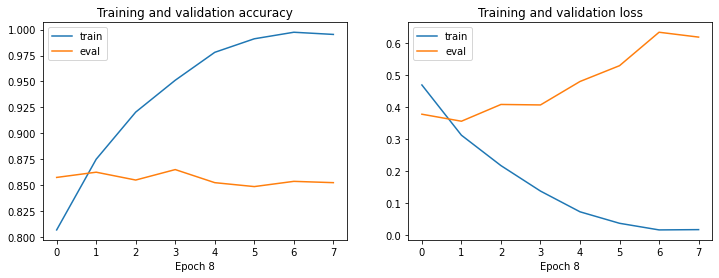

In [21]:
import matplotlib.pyplot as plt

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 4))

plt1.plot(train_acc_lists, label='train')
plt1.plot(eval_acc_lists, label='eval')
plt1.set_title('Training and validation accuracy')
plt1.legend()
plt1.set(xlabel='Epoch 8')

plt2.plot(train_loss_lists, label='train')
plt2.plot(eval_loss_lists, label='eval')
plt2.set_title('Training and validation loss')
plt2.legend()
plt2.set(xlabel='Epoch 8')

In [22]:
test_dataset.data.shape

(793, 2)

In [23]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

  0%|          | 0/199 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 199/199 [00:03<00:00, 52.14it/s]

     index     label
0        0  positive
1        1   neutral
2        2  positive
3        3  positive
4        4  positive
..     ...       ...
788    788   neutral
789    789  negative
790    790   neutral
791    791  positive
792    792  positive

[793 rows x 2 columns]


In [24]:
model.save_pretrained('finetuned-model-train')

## Test Fine-tuned Model on Sample Sentences

In [25]:
text = 'Widih apk ini memang bagus saya main game jadi tidak ngelag. Apk nya sangat bagus saya tidak rugi ngedownload apk ini.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Widih apk ini memang bagus saya main game jadi tidak ngelag. Apk nya sangat bagus saya tidak rugi ngedownload apk ini. | Label : positive (99.954%)


In [26]:
text = 'gua foto ktp udh sejelas mungkin masih saja tidak bisa kenapa sih bikin males aja'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: gua foto ktp udh sejelas mungkin masih saja tidak bisa kenapa sih bikin males aja | Label : negative (99.709%)


# Penghitungan Akurasi

In [27]:
pred = pd.read_csv('pred.txt')

In [28]:
daftar_prediksi = []

for i in pred['label'] :
  if i == 'negative':
    daftar_prediksi.append(0)
  elif i == 'neutral':
    daftar_prediksi.append(1)
  else :
    daftar_prediksi.append(2)

In [29]:
data_test = pd.read_csv('test_int.csv')

Accuracy score is 86%.

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       188
           1       0.57      0.61      0.59        96
           2       0.93      0.92      0.93       509

    accuracy                           0.86       793
   macro avg       0.78      0.78      0.78       793
weighted avg       0.86      0.86      0.86       793


Confusion Matrix:


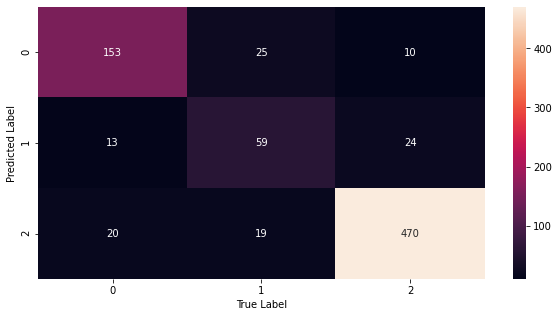

In [30]:
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

accuracy = accuracy_score(data_test['sentiment'], daftar_prediksi) * 100
print("Accuracy score is {}%.".format(round(accuracy),1))
print()
print("Classification Report:")
print(classification_report(data_test['sentiment'], daftar_prediksi))
print()

print("Confusion Matrix:")
f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(data_test['sentiment'], daftar_prediksi), annot=True, fmt=".0f", ax=ax)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

# Plotting

In [31]:
file_test_asli = pd.read_csv('test.csv')

In [32]:
jumlah_0_asli = 0
jumlah_1_asli = 0
jumlah_2_asli = 0

for i in file_test_asli['sentiment'] :
  if i == 'negative' :
    jumlah_0_asli += 1
  elif i == 'neutral':
    jumlah_1_asli += 1
  else :
    jumlah_2_asli += 1

print(jumlah_0_asli)
print(jumlah_1_asli)
print(jumlah_2_asli)

188
96
509


In [33]:
jumlah_0_pred = 0
jumlah_1_pred = 0
jumlah_2_pred = 0

for i in daftar_prediksi :
  if i == 0 :
    jumlah_0_pred += 1
  elif i == 1 :
    jumlah_1_pred += 1
  else :
    jumlah_2_pred += 1

print(jumlah_0_pred)
print(jumlah_1_pred)
print(jumlah_2_pred)

186
103
504


[]

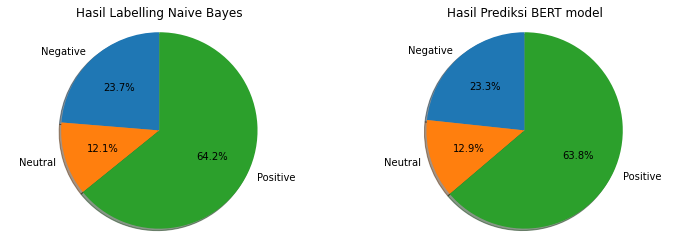

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# File Asli
labels = 'Negative','Neutral','Positive'
sizes = [jumlah_0_asli, jumlah_1_asli, jumlah_2_asli]
explode = (0, 0, 0)

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Hasil Labelling Naive Bayes')


# Hasil Prediksi
labels = 'Negative','Neutral','Positive'
sizes = [jumlah_0_pred, jumlah_1_pred, jumlah_2_asli]
explode = (0, 0, 0) 

ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Hasil Prediksi BERT model')

ax1.plot()
ax2.plot()

In [35]:
print(logits)

tensor([[ 4.7910, -1.1134, -3.7803]], device='cuda:0')


In [36]:
print(torch.topk(logits, 2))

torch.return_types.topk(
values=tensor([[ 4.7910, -1.1134]], device='cuda:0'),
indices=tensor([[0, 1]], device='cuda:0'))
